# Classifying overall expression level categories (ELC)

In [1]:
set.seed(42) # For reproducibility of results

In [3]:
library(tidyverse, warn.conflicts = FALSE)
library(foreach, warn.conflicts = FALSE)
library(doParallel, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(data.table, warn.conflicts = FALSE)
library(RPostgreSQL, warn.conflicts = FALSE)

In [4]:
# import count table
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
hord <- readRDS("barley_count_table_paired.rds")
d <- hord$counts
dim(d)
head(d)
# dimensions shows that a total of 180 samples were mapped to 123 075 genes of T.aestivum

[1] 49281   193

,ERR1248084,ERR1248085,ERR1248086,ERR1248087,ERR1248088,ERR1248089,ERR1248116,ERR1248117,ERR1248118,ERR1248119,⋯,ERR515188,ERR515189,ERR515190,ERR515191,ERR515192,ERR515193,ERR515194,ERR515195,ERR515196,ERR515197
Horvu_MOREX_1H01G000100,1102.000,2178.000,2399.000,3877.000,925.000,2010.000,1773.00,2407.000,2224.000,3328.000,⋯,1232.000,2237.000,1503.000,1833.000,1695.000,2477.000,2265.000,2578.000,2468.000,2317.000
Horvu_MOREX_1H01G000200,3.000,4.000,38.000,14.000,1.000,65.000,641.00,2034.000,2230.000,2022.000,⋯,1.000,3.000,10.000,1.000,2.000,8.000,6.000,0.000,2.000,2.000
Horvu_MOREX_1H01G000300,346.000,682.000,613.000,1097.000,369.000,903.000,1513.00,2346.000,2464.000,2226.000,⋯,428.000,610.000,519.000,466.000,492.000,652.000,569.000,677.000,710.000,584.000
Horvu_MOREX_1H01G000400,1282.000,1703.000,681.000,1293.000,1645.000,1748.000,490.00,484.000,578.000,685.000,⋯,971.000,1640.000,1312.000,1160.000,2093.000,2738.000,2795.000,3687.000,3044.000,3045.000
Horvu_MOREX_1H01G000500,2693.000,5151.000,2940.000,4303.000,3550.000,3758.000,1589.00,2689.000,2926.000,3255.000,⋯,3656.000,4336.000,4734.000,4469.000,2296.000,2418.000,2349.000,3908.000,3340.000,3221.000
Horvu_MOREX_1H01G000600,1759.535,2989.789,1806.463,2680.405,2580.237,3770.057,2290.44,2551.647,2561.501,2173.419,⋯,2808.661,3316.393,2766.549,2833.275,2984.255,4250.868,3915.629,4172.974,4106.843,4045.146


In [5]:
non.expr.cutoff=0.5

In [6]:
#m=as.data.frame(d, stringsAsFactors=FALSE)
#m$locus=row.names(d)
#m <- pivot_longer(m, cols = c(1:193), names_to ="sample",values_to="tpm")
#m <- arrange(m,locus,sample)
#m$tpm <- as.integer(m$tpm)

m=as.data.table(d)
m$locus=row.names(d)
m=melt(m,id.vars=c("locus"),variable.name="sample_id",value.name="tpm")
setkey(m,locus,sample_id)

head(m)
nrow(m)

locus,sample_id,tpm
<chr>,<fct>,<dbl>
Horvu_MOREX_1H01G000100,ERR1248084,1102
Horvu_MOREX_1H01G000100,ERR1248085,2178
Horvu_MOREX_1H01G000100,ERR1248086,2399
Horvu_MOREX_1H01G000100,ERR1248087,3877
Horvu_MOREX_1H01G000100,ERR1248088,925
Horvu_MOREX_1H01G000100,ERR1248089,2010


[1] 9511233

In [15]:
tau_func<-function(x){
  if(any(is.na(x))) stop('NA\'s need to be 0.')
  if(any(x<0)) stop('Negative input values not permitted. Maybe data is log transformed?')
  t<-sum(1-x/max(x))/(length(x)-1)
}

In [16]:
head(d)
tau=apply(d,1,tau_func)
head(tau)

,ERR1248084,ERR1248085,ERR1248086,ERR1248087,ERR1248088,ERR1248089,ERR1248116,ERR1248117,ERR1248118,ERR1248119,⋯,ERR515188,ERR515189,ERR515190,ERR515191,ERR515192,ERR515193,ERR515194,ERR515195,ERR515196,ERR515197
Horvu_MOREX_1H01G000100,1102.000,2178.000,2399.000,3877.000,925.000,2010.000,1773.00,2407.000,2224.000,3328.000,⋯,1232.000,2237.000,1503.000,1833.000,1695.000,2477.000,2265.000,2578.000,2468.000,2317.000
Horvu_MOREX_1H01G000200,3.000,4.000,38.000,14.000,1.000,65.000,641.00,2034.000,2230.000,2022.000,⋯,1.000,3.000,10.000,1.000,2.000,8.000,6.000,0.000,2.000,2.000
Horvu_MOREX_1H01G000300,346.000,682.000,613.000,1097.000,369.000,903.000,1513.00,2346.000,2464.000,2226.000,⋯,428.000,610.000,519.000,466.000,492.000,652.000,569.000,677.000,710.000,584.000
Horvu_MOREX_1H01G000400,1282.000,1703.000,681.000,1293.000,1645.000,1748.000,490.00,484.000,578.000,685.000,⋯,971.000,1640.000,1312.000,1160.000,2093.000,2738.000,2795.000,3687.000,3044.000,3045.000
Horvu_MOREX_1H01G000500,2693.000,5151.000,2940.000,4303.000,3550.000,3758.000,1589.00,2689.000,2926.000,3255.000,⋯,3656.000,4336.000,4734.000,4469.000,2296.000,2418.000,2349.000,3908.000,3340.000,3221.000
Horvu_MOREX_1H01G000600,1759.535,2989.789,1806.463,2680.405,2580.237,3770.057,2290.44,2551.647,2561.501,2173.419,⋯,2808.661,3316.393,2766.549,2833.275,2984.255,4250.868,3915.629,4172.974,4106.843,4045.146


Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200 Horvu_MOREX_1H01G000300 
              0.8494650               0.9272515               0.8425131 
Horvu_MOREX_1H01G000400 Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600 
              0.8527038               0.7987692               0.6767593

In [12]:
#Mall <- mutate(m, sample=sample, min_tpm=min(tpm,na.rm=TRUE),median_tpm=median(tpm,na.rm=TRUE),max_tpm=max(tpm,na.rm=TRUE),breadth=length(tpm[tpm>non.expr.cutoff])/length(tpm))
#Mall <- select(Mall, sample, locus, min_tpm, median_tpm, max_tpm, breadth)
# setkey sorts a data.table and marks it as sorted with an attribute sorted. The sorted columns are the key. 
# The key can be any number of columns. The columns are always sorted in ascending order. 
# The table is changed by reference and setkey is very memory efficient
#Mall <- arrange(Mall,sample)
#Mall$sample <- as.character(Mall$sample)
#Mall$breadth <- as.integer(Mall$breadth)

Mall = m[,list(sample_id=sample_id, min_tpm=min(tpm,na.rm=TRUE),median_tpm=median(tpm,na.rm=TRUE),max_tpm=max(tpm,na.rm=TRUE),breadth=length(tpm[tpm>non.expr.cutoff])/length(tpm)),by=list(locus)]
Mall = data.table(sample=Mall$sample_id, locus=Mall$locus,min_tpm=Mall$min_tpm, median_tpm=Mall$median_tpm, max_tpm=Mall$max_tpm, breadth=Mall$breadth)
setkey(Mall,locus)

head(Mall)
nrow(Mall)

sample,locus,min_tpm,median_tpm,max_tpm,breadth
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ERR1248084,Horvu_MOREX_1H01G000100,207,1389,9724,1
ERR1248085,Horvu_MOREX_1H01G000100,207,1389,9724,1
ERR1248086,Horvu_MOREX_1H01G000100,207,1389,9724,1
ERR1248087,Horvu_MOREX_1H01G000100,207,1389,9724,1
ERR1248088,Horvu_MOREX_1H01G000100,207,1389,9724,1
ERR1248089,Horvu_MOREX_1H01G000100,207,1389,9724,1


[1] 9511233

In [17]:
#tau <- as.data.frame(tau, stringsAsFactors = FALSE)
#tau$locus <- row.names(tau)
#tau <- arrange(tau,locus)

tau=as.data.table(data.frame(locus=names(tau),tau=tau))
setkey(tau,locus)

head(tau)
nrow(tau)

locus,tau
<fct>,<dbl>
Horvu_MOREX_1H01G000100,0.8494650
Horvu_MOREX_1H01G000200,0.9272515
Horvu_MOREX_1H01G000300,0.8425131
Horvu_MOREX_1H01G000400,0.8527038
Horvu_MOREX_1H01G000500,0.7987692
Horvu_MOREX_1H01G000600,0.6767593


[1] 49281

In [18]:
#Mall <- full_join(Mall,tau, by= "locus")
#Mall$min_tpm <- as.numeric(Mall$min_tpm)
#Mall$median_tpm <- as.numeric(Mall$median_tpm)
#Mall$max_tpm <- as.numeric(Mall$max_tpm)
Mall=merge(Mall,tau)
head(Mall)

locus,sample,min_tpm,median_tpm,max_tpm,breadth,tau
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Horvu_MOREX_1H01G000100,ERR1248084,207,1389,9724,1,0.849465
Horvu_MOREX_1H01G000100,ERR1248085,207,1389,9724,1,0.849465
Horvu_MOREX_1H01G000100,ERR1248086,207,1389,9724,1,0.849465
Horvu_MOREX_1H01G000100,ERR1248087,207,1389,9724,1,0.849465
Horvu_MOREX_1H01G000100,ERR1248088,207,1389,9724,1,0.849465
Horvu_MOREX_1H01G000100,ERR1248089,207,1389,9724,1,0.849465


In [19]:
nrow(Mall)
ncol(Mall)

[1] 9511233

[1] 7

In [20]:
get_elc=function(cut,f,n) {
    s=Mall
    sx=s[s[[f]]>cut]
    k=kmeans(log(sx[,f,with=FALSE]+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[s[[f]]>cut]=kk
    so=data.frame(o=so)
    names(so)[ncol(so)]=gsub("tpm","elc",n)
    so
}

In [26]:
sx=Mall[Mall[[3:5]]>0.5]

ERROR: Error: recursive indexing failed at level 2



In [22]:
cl <- makeCluster(60)
registerDoParallel(cl)
MO <- foreach(i=1:9511233,
              .combine="cbind") %dopar% get_elc(non.expr.cutoff,i,names(Mall)[i])
stopCluster(cl)

MO <- inner_join(Mall, MO, by = "locus")
MO <- arrange(MO,sample)

ERROR: Error in get_elc(non.expr.cutoff, i, names(Mall)[i]): task 1 failed - "undefined columns selected"


In [17]:
MO = as.data.table(MO)
MO[,blc:=cut(breadth,breaks=seq(0,1,0.2,),include.lowest=TRUE,ordered.result=TRUE,labels=c("very few","few","medium","many","most")),by=list(locus)]
head(MO)

locus,min_tpm,median_tpm,max_tpm,breadth,tau,min_elc,median_elc,max_elc,blc
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<fct>
Horvu_MOREX_1H01G000100,207,1389.000,9724.000,1.0000000,0.8494650,E4,E4,E4,most
Horvu_MOREX_1H01G000200,0,6.000,2230.000,0.8031088,0.9272515,E0,E1,E3,most
Horvu_MOREX_1H01G000300,17,329.000,2775.000,1.0000000,0.8425131,E2,E3,E3,most
Horvu_MOREX_1H01G000400,16,583.000,6124.000,1.0000000,0.8527038,E2,E4,E4,most
Horvu_MOREX_1H01G000500,181,1891.000,11441.000,1.0000000,0.7987692,E4,E4,E4,most
Horvu_MOREX_1H01G000600,38,1005.952,4267.252,1.0000000,0.6767593,E3,E4,E4,most


In [ ]:
setwd("/home/vanda.marosi/floral_development_thesis_vm/")
barley_meta <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
glimpse(barley_meta)
# create subset of paired reads
barley_meta_p <- select(barley_meta, Run.ID, Dataset, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta_p) <- c("sample", "dataset", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
barley_meta_p <- group_by(barley_meta_p, library)
barley_meta_p <- filter(barley_meta_p, library == "paired")
barley_meta_p <- as.data.frame(ungroup(barley_meta_p))
rownames(barley_meta_p) <- barley_meta_p$sample
glimpse(barley_meta_p)
head(barley_meta_p)

In [26]:
MO <- as.data.frame(MO)
elc <- select(MO, sample, locus, median_elc) %>% 
        group_by(MO, sample) %>% 
        summarize(MO, E0 = n_distinct(E0), E1 = n_distinct(E1), E2 = n_distinct(E2), E3 = n_distinct(E3), E4 = n_distinct(E4)) %>%
        mutate(MO, sum = E0 + E1 + E2 + E3 + E4)
head(elc)
elc_meta <- inner_join(elc, barley_meta_p, by = "sample")
head(elc_meta)

,geneid,min_tpm,median_tpm,max_tpm,breadth,tau,min_elc,median_elc,max_elc,blc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<fct>
1,Horvu_MOREX_1H01G000100,207,1389.000,9724.000,1.0000000,0.8494650,E4,E4,E4,most
2,Horvu_MOREX_1H01G000200,0,6.000,2230.000,0.8031088,0.9272515,E0,E1,E3,most
3,Horvu_MOREX_1H01G000300,17,329.000,2775.000,1.0000000,0.8425131,E2,E3,E3,most
4,Horvu_MOREX_1H01G000400,16,583.000,6124.000,1.0000000,0.8527038,E2,E4,E4,most
5,Horvu_MOREX_1H01G000500,181,1891.000,11441.000,1.0000000,0.7987692,E4,E4,E4,most
6,Horvu_MOREX_1H01G000600,38,1005.952,4267.252,1.0000000,0.6767593,E3,E4,E4,most


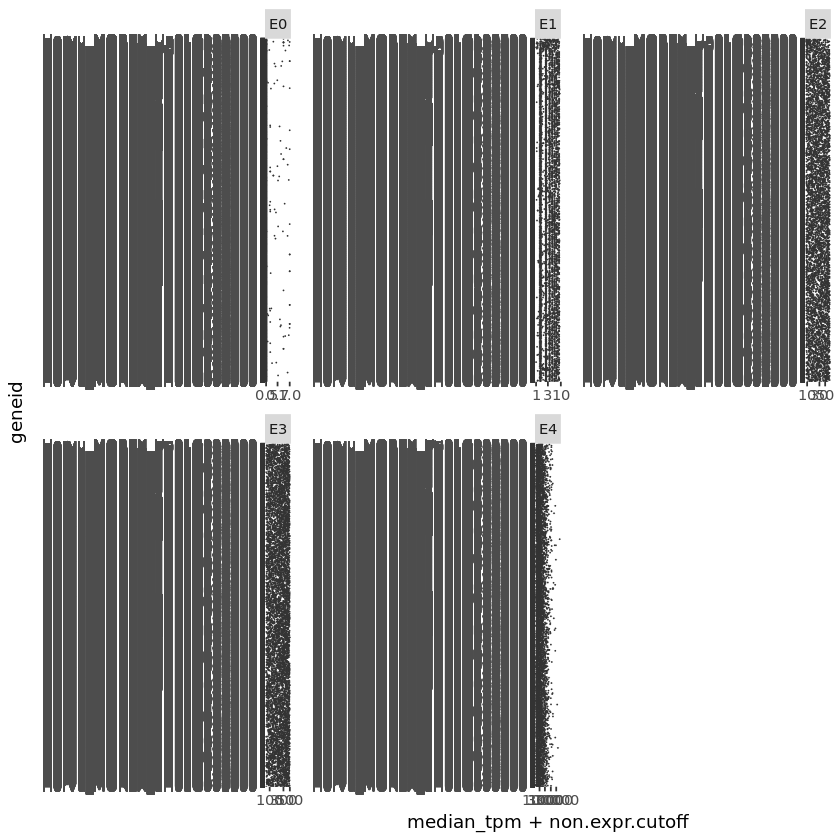

In [27]:
ggplot(elc_meta, aes(fill = median_elc, y = sum, x = sample)) +
        geom_bar(position = "fill", stat = "identity") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes (%)")
        facet_wrap( ~ dataset, ncol = 3)

#ggplot(na.omit(MO), aes( x = sample) + 
#        geom_boxplot() + 
#        facet_wrap(~median_elc,scales="free") + 
#        scale_y_log10() +
#        coord_flip()
# na.omit returns values excluding NAs

In [ ]:
sessionInfo()